In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!kaggle datasets download -d lara311/flowers-five-classes

Dataset URL: https://www.kaggle.com/datasets/lara311/flowers-five-classes
License(s): apache-2.0
 97% 153M/158M [00:01<00:00, 157MB/s]
100% 158M/158M [00:01<00:00, 142MB/s]


In [ ]:
!unzip -qq flowers-five-classes.zip -d flowers-five-classes1

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time
import cv2
from IPython import display

In [ ]:
list_paths = []
for folder in os.listdir('/content/flowers-five-classes1/train'):
  for file in os.listdir('/content/flowers-five-classes1/train/'+folder):
    list_paths.append('/content/flowers-five-classes1/train/'+folder+'/'+file)

print(list_paths)

['/content/flowers-five-classes1/train/sunflower/7176723954_e41618edc1_n.jpg', '/content/flowers-five-classes1/train/sunflower/4933229889_c5d9e36392.jpg', '/content/flowers-five-classes1/train/sunflower/20183028616_beb937e75c_m.jpg', '/content/flowers-five-classes1/train/sunflower/9555824387_32b151e9b0_m.jpg', '/content/flowers-five-classes1/train/sunflower/20406385204_469f6749e2_n.jpg', '/content/flowers-five-classes1/train/sunflower/16967372357_15b1b9a812_n.jpg', '/content/flowers-five-classes1/train/sunflower/6606749757_b98a4ba403.jpg', '/content/flowers-five-classes1/train/sunflower/4932736308_827012cff2.jpg', '/content/flowers-five-classes1/train/sunflower/4977385375_e271e282f9.jpg', '/content/flowers-five-classes1/train/sunflower/22429946721_e17a12cb39_n.jpg', '/content/flowers-five-classes1/train/sunflower/5970868068_fe1c8b282e_n.jpg', '/content/flowers-five-classes1/train/sunflower/7012366081_019c8a17a4_m.jpg', '/content/flowers-five-classes1/train/sunflower/8480886751_71d88bfd

In [ ]:
len(list_paths)

2746

In [ ]:
array_list = []
for i in list_paths:
  img = cv2.imread(i)
  img = cv2.resize(img, (100, 100))
  array_list.append(img)
array_list = np.array(array_list)

array([[[101, 139, 116],
        [ 86, 145, 114],
        [153, 178, 169],
        ...,
        [  3,  21,   9],
        [ 14,  36,  22],
        [  9,  37,  18]],

       [[142, 205, 166],
        [ 55, 114, 121],
        [ 77, 124, 144],
        ...,
        [  5,  25,  13],
        [ 11,  33,  23],
        [ 16,  41,  27]],

       [[ 92, 148, 198],
        [ 97, 134, 213],
        [133, 158, 214],
        ...,
        [  9,  30,  31],
        [ 19,  41,  41],
        [ 20,  49,  41]],

       ...,

       [[ 14, 130,  77],
        [136, 184, 149],
        [ 87, 186, 146],
        ...,
        [ 23, 148,  74],
        [ 72, 180, 106],
        [ 32, 108,  43]],

       [[ 83, 165, 112],
        [ 41, 136,  77],
        [ 37, 154,  86],
        ...,
        [ 10,  94,  41],
        [ 65, 110,  72],
        [ 19,  78,  27]],

       [[ 82, 160, 113],
        [ 71, 142,  88],
        [ 87, 143,  92],
        ...,
        [ 27, 102,  51],
        [ 39,  97,  40],
        [ 39, 104,  44]]], dtype=uint8)
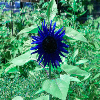

In [ ]:
array_list[10]

In [ ]:
# Convert to float32
train_images = array_list.astype('float32')

# Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5


In [ ]:
BUFFER_SIZE = 2746
BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(25*25*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((25, 25, 256)))
    assert model.output_shape == (None, 25, 25, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 50, 50, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 100, 100, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(3, (5, 5), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 100, 100, 3)

    return model

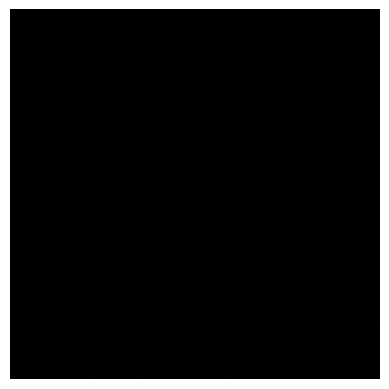

In [ ]:
generator = make_generator_model()
noise = tf.random.uniform([1, 100], -1, 1)
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0])
plt.axis('off')
plt.show()

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[100, 100, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-2.7921818e-05]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 30
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

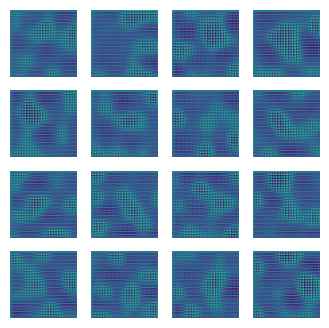

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))